# Visualize maximum SWE, mean soil water, mean ET and mean runoff per GRU
Needs: 
- Catchment shapefile with GRU delineation
- River shapefile with network delineation
- SUMMA output `scalarSWE`, `scalarTotalSoilWat`, `scalarTotalET`
- mizuRoute output `IRFroutedRunoff`

#### Special note
SUMMA and mizuRoute simulations have been preprocessed into single value statistics per model element, using auxiliary scripts in `~/summaWorkflow_public/0_tools/`. Paths to the `.nc` files that contain these statistics are not read from the `control_active.txt` file but hard-coded the sections "Simulation statistics file locations" below.

To improve visualization of large lakes, HydroLAKES lake delineations are plotted on top of the catchment GRUs and river segments. Dealing with HydroLAKES inputs is not considered within scope of the workflow and therefore requires some manual downloading and preprocessing of this data for those who wish to reproduce this step. The relevant code is easily disabled by switching the `plot_lakes = True` flag to `False`.

In [1]:
# modules
import pyproj
import matplotlib
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from geocube.api.core import make_geocube
import cartopy.crs as ccrs
%matplotlib inline

#### Control file handling

In [2]:
# Easy access to control file folder
controlFolder = Path('../0_control_files')

In [3]:
# Store the name of the 'active' file in a variable
controlFile = 'control_Yukon_Merit.txt'

In [4]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line and not line.startswith('#'):
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [5]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

In [6]:
#### Simulation statistics file locations

In [7]:
# SUMMA simulations
root_path = read_from_control(controlFolder/controlFile,'root_path')
experiment_id = read_from_control(controlFolder/controlFile,'experiment_id')
domain_name = read_from_control(controlFolder/controlFile,'domain_name')

summa_output_path = Path(root_path + '/domain_' + domain_name + '/simulations/' + experiment_id + '/SUMMA/')
summa_output_name = Path(experiment_id + '_day.nc')

In [8]:
# mizuRoute simulations\


root_path = read_from_control(controlFolder/controlFile,'root_path')
experiment_id = read_from_control(controlFolder/controlFile,'experiment_id')
domain_name = read_from_control(controlFolder/controlFile,'domain_name')
experiment_time_start = read_from_control(controlFolder/controlFile,'experiment_time_start')
experiment_time_end = read_from_control(controlFolder/controlFile,'experiment_time_end')

mizu_output_path = Path(root_path + '/domain_' + domain_name + '/simulations/' + experiment_id + '/mizuRoute/')
mizu_output_name = Path(experiment_id + '.h.' + experiment_time_start[:4] + '-01-01-00000.nc')


## Define where to save the output 

In [9]:
# Path and filename
fig_path = read_from_control(controlFolder/controlFile,'visualization_folder')
fig_name = 'SUMMA_mizuRoute_vars_' + domain_name + '.png'

# Specify default path if needed
if fig_path == 'default':
    fig_path = make_default_path('visualization') # outputs a Path()
else:
    fig_path = Path(fig_path) # make sure a user-specified path is a Path()
    
# Make the folder if it doesn't exist
fig_path.mkdir(parents=True, exist_ok=True)

#### Catchment shapefile location and variable names

In [10]:
# HM catchment shapefile path & name
hm_catchment_path = read_from_control(controlFolder/controlFile,'catchment_shp_path')
hm_catchment_name = read_from_control(controlFolder/controlFile,'catchment_shp_name')

# Specify default path if needed
if hm_catchment_path == 'default':
    hm_catchment_path = make_default_path('shapefiles/catchment') # outputs a Path()
else:
    hm_catchment_path = Path(hm_catchment_path) # make sure a user-specified path is a Path()

In [11]:
# Find the GRU and HRU identifiers
hm_hruid = read_from_control(controlFolder/controlFile,'catchment_shp_hruid')

#### River network shapefile location and variable names

In [12]:
# River network path & name
river_network_path = read_from_control(controlFolder/controlFile,'river_network_shp_path')
river_network_name = read_from_control(controlFolder/controlFile,'river_network_shp_name')

# Specify default path if needed
if river_network_path == 'default':
    river_network_path = make_default_path('shapefiles/river_network') # outputs a Path()
else:
    river_network_path = Path(river_network_path) # make sure a user-specified path is a Path()

In [13]:
# Find the segment ID
seg_id = read_from_control(controlFolder/controlFile,'river_network_shp_segid')

#### Load all shapefiles and project to Albers Conformal Conic

In [14]:
# catchment shapefile
bas = gpd.read_file(hm_catchment_path/hm_catchment_name)

In [15]:
# river network shapefile
riv = gpd.read_file(river_network_path/river_network_name)

In [16]:
# Set the target CRS
acc = 'ESRI:102008'

In [17]:
# Reproject
bas_albers = bas#.to_crs(acc)
riv_albers = riv#.to_crs(acc)

In [18]:
# Print the median basin size for curiousity
print('median area = {} m^2'.format(bas['HRU_area'].median() / 10**6))
print('mean area   = {} m^2'.format(bas['HRU_area'].mean() / 10**6))

median area = 41.36456243 m^2
mean area   = 50.61591749084417 m^2


### Pre-processing
#### Map SUMMA sims to catchment shapes

In [19]:
# Get the aggregated statistics of SUMMA simulation
summa = xr.open_dataset(summa_output_path/summa_output_name)

In [20]:
# Specify variables of interest
plot_vars = ['scalarSWE','scalarTotalET','scalarTotalSoilWat']

In [21]:
# Match the accummulated values to the correct HRU IDs in the shapefile
hru_ids_shp = bas_albers[hm_hruid].astype(int) # hru order in shapefile

In [22]:
# Match the accummulated values to the correct HRU IDs in the shapefile
#hru_ids_shp = bas_albers[hm_hruid].astype(int) # hru order in shapefile

#for plot_var in plot_vars:
#    bas_albers[plot_var] = summa[plot_var].sel(hru=hru_ids_shp.values, time = experiment_time_end[:10]).values


In [23]:
hru_ids_shp = riv_albers[hm_hruid].astype(int)
hru_ids_shp

0        81001460
1        81001703
2        81001738
3        81001746
4        81001836
           ...   
18218    81036213
18219    81036215
18220    81036216
18221    81036221
18222    81036235
Name: COMID, Length: 18223, dtype: int64

#### Map mizuRoute sims to river shapes

In [24]:
# Get the aggregated statistics of mizuRoute simulations
mizu = xr.open_dataset(mizu_output_path/mizu_output_name)
mizu

<xarray.Dataset> Size: 3GB
Dimensions:          (time: 8760, seg: 18223, hru: 18225)
Coordinates:
  * time             (time) datetime64[ns] 70kB 1979-01-01 ... 1979-12-31T23:...
Dimensions without coordinates: seg, hru
Data variables:
    reachID          (seg) int32 73kB ...
    basinID          (hru) int32 73kB ...
    basRunoff        (time, hru) float32 639MB ...
    instRunoff       (time, seg) float32 639MB ...
    dlayRunoff       (time, seg) float32 639MB ...
    IRFroutedRunoff  (time, seg) float32 639MB ...
Attributes:
    mizuRoute-version:  undefined
    gitBranch:          undefined
    gitHash:            undefined

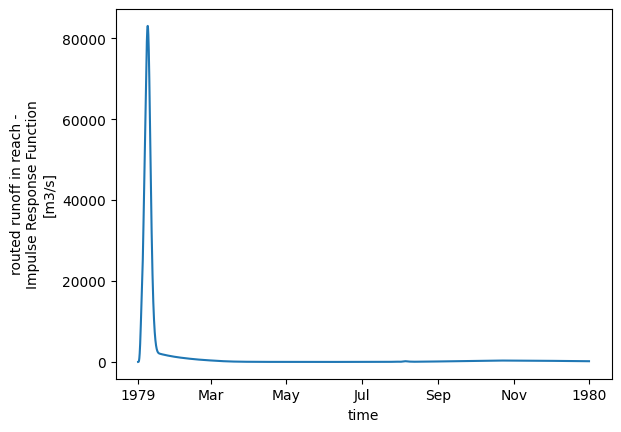

In [25]:
reach = mizu.sel(seg = 61)

fig,ax = plt.subplots()
plt.rcParams.update({'font.size': 8}) # must set in top
reach['IRFroutedRunoff'].plot(ax = ax)
#x.set_xlim(pd.to_datetime([experiment_time_end[:4] + '-01-01',experiment_time_end]))
#ax.set_ylim([0,1])

In [26]:
#fig,ax = plt.subplots()
#plt.rcParams.update({'font.size': 23}) # must set in top
#
#summa['scalarTotalET'].sel(hru = 354).plot(ax=ax)

In [27]:
# Specify variables of interest
mizu_vars = ['IRFroutedRunoff']#,'KWTroutedRunoff']

In [28]:
# polygon order in the simulation file
seg_ids_sim = mizu['reachID'].values

In [29]:
# ensure that the shapefile is in the same order as the sims
riv_albers = riv_albers.set_index(riv_albers[seg_id].astype('int'))
riv_albers = riv_albers.reindex(seg_ids_sim)

In [30]:
# Match the accummulated values to the correct HRU IDs in the shapefile
seg_ids_riv = riv_albers.index.values # hru order in shapefile
for mizu_var in mizu_vars:
    riv_albers[mizu_var] = mizu[mizu_var].sel(seg=np.where(mizu['reachID'].values == seg_ids_riv)[0]).values[0]

In [31]:
# Add a linewidth column for the river network
riv_albers['lineWidth'] = np.maximum(np.log10(riv_albers['IRFroutedRunoff'] ),0)

### Figure

In [32]:
# Set the font size: we need this to be huge so we can also make our plotting area huge, to avoid a gnarly plotting bug
if 'compressed' in fig_name:
    plt.rcParams.update({'font.size': 25})
else:
    plt.rcParams.update({'font.size': 100})

In [33]:
# Flip the evaporation values so that they become positive
#bas_albers['plot_ET'] = bas_albers['scalarTotalET'] * -1
#bas_albers['plot_ET'] = bas_albers['plot_ET'].where(bas_albers['scalarTotalET'] != -9999, np.nan)


             COMID   lengthkm  lengthdir  sinuosity     slope      uparea  \
COMID                                                                       
81001460  81001460   4.748463   3.663204   1.296259  0.024595   36.307630   
81001703  81001703   1.022885   0.624579   1.637718  0.006723  443.412235   
81001738  81001738   1.381042   0.896199   1.540999  0.006350  588.192407   
81001746  81001746   6.984657   5.108901   1.367154  0.006435  408.434350   
81001836  81001836  14.254925  10.247571   1.391054  0.006915  501.583912   
...            ...        ...        ...        ...       ...         ...   
81036213  81036213  17.619041  10.166344   1.733075  0.013239   95.458992   
81036215  81036215   2.064154   1.701468   1.213160  0.000870   28.087386   
81036216  81036216  10.289805   8.493184   1.211537  0.051553   77.292962   
81036221  81036221  11.501295   8.935199   1.287190  0.021181   88.049471   
81036235  81036235  15.132569   9.057801   1.670667  0.009373   72.451932   

/var/folders/pc/q8630ffx72z0bwfzz59ws0kc0000gn/T/ipykernel_14313/861967346.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.drop('COMID', axis = 1).to_file(save_path)


/Users/darrieythorsson/compHydro/data/CWARHM_data/domain_Yukon/visualization/Yukon_run_Yukon_Merit_1_routedRunoff.shp


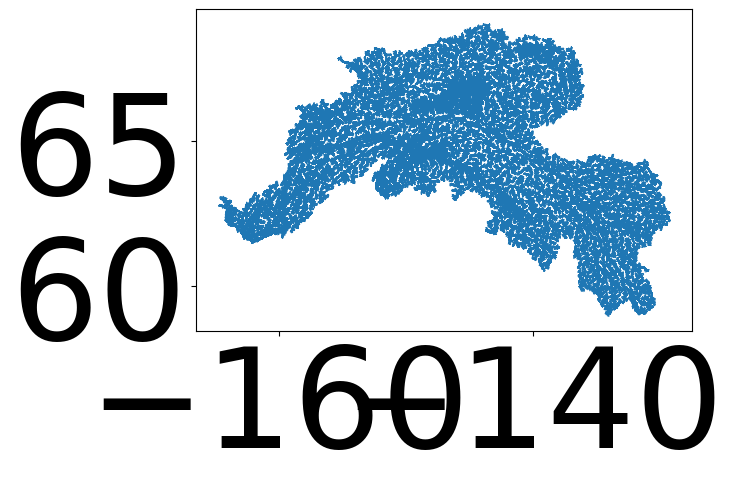

In [34]:
riv_albers

gdf = gpd.GeoDataFrame(
    riv_albers,
    geometry=riv_albers.geometry
)

save_path = root_path/Path('domain_' + domain_name)/Path('visualization')/Path(domain_name + '_' + experiment_id + '_routedRunoff.shp')
print(gdf)
gdf.drop('COMID', axis = 1).to_file(save_path)
#gdf.drop('LINKNO', axis = 1).to_file("/Users/darrieythorsson/compHydro/data/YukonDisTDX.shp")
gdf.plot() # first image hereunder
print(save_path)

"\n# lakes\nif plot_lakes:\n    large_lakes_albers.plot(ax=axs, color=lake_col, zorder=1)\n    #large_lakes_albers.plot(ax=axs[0,1], color=lake_col, zorder=1)\n    #large_lakes_albers.plot(ax=axs[1,0], color=lake_col, zorder=1)\n    #large_lakes_albers.plot(ax=axs[1,1], color=lake_col, zorder=1)\n\n# Save \nplt.savefig(fig_path/fig_name, bbox_inches='tight', transparent=True)\n"

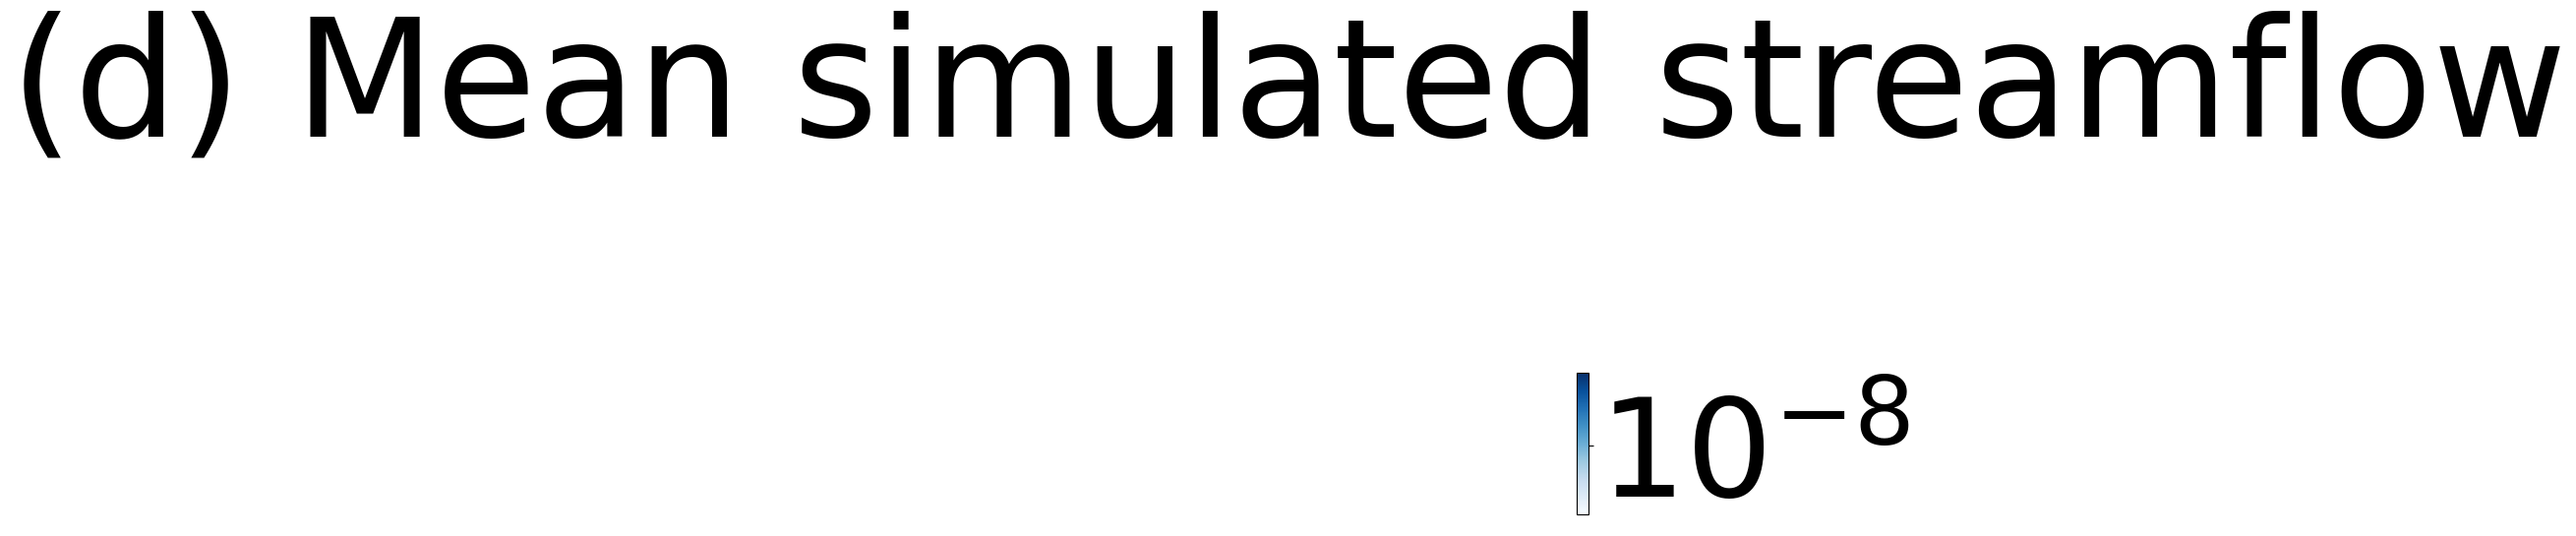

In [35]:
'''if 'compressed' in fig_name:
    fig,axs = plt.subplots(2,2,figsize=(35,33))
else:
    fig,axs = plt.subplots(2,2,figsize=(140,133))

# colorbar axes

cax2 = fig.add_axes([0.97 ,0.60,0.02,0.3])
cax3 = fig.add_axes([0.473,0.10,0.02,0.3])

'''


fig,axs = plt.subplots()
#plt.tight_layout()
'''
cax1 = fig.add_axes([0.473,0.60,0.02,0.3])
# add maps
bas_albers.plot(ax=axs, column='scalarSWE', edgecolor='none', legend=True, vmin=0, vmax=200, \
                cmap='Greys_r', cax=cax1, zorder=0)
axs.set_title('(a) Maximum simulated Snow Water Equivalent')
axs.axis('off')
cax1.set_ylabel('scalarSWE $[kg~m^{-2}]$',labelpad=-600)

# SM
bas_albers.plot(ax=axs[0,1], column='scalarTotalSoilWat', edgecolor='none', legend=True, vmin=0, \
                cmap='cividis_r', cax=cax2, zorder=0)
axs[0,1].set_title('(b) Mean simulated total soil water content')
axs[0,1].axis('off')
cax2.set_ylabel('scalarTotalSoilWat $[kg~m^{-2}]$',labelpad=-600)

# ET
bas_albers.plot(ax=axs[1,0], column='plot_ET', edgecolor='none', legend=True,\
                cmap='viridis', cax=cax3, zorder=0)
axs[1,0].set_title('(c) Mean simulated total evapotranspiration')
axs[1,0].axis('off')
cax3.set_ylabel('scalarTotalET $[kg~m^{-2}~s^{-1}]$',labelpad=-450)
'''
# Flow
cax4 = fig.add_axes([0.97 ,0.10,0.02,0.3])
var = 'IRFroutedRunoff'
norm = matplotlib.colors.LogNorm(vmin=riv_albers[var].min(), vmax=riv_albers[var].max())
riv_albers.plot(ax=axs,column=var, linewidth=riv_albers['lineWidth']*10, \
                                    cmap='Blues', legend=True, cax=cax4, norm=norm, zorder=0)
axs.set_title('(d) Mean simulated streamflow')
axs.axis('off')

'''
# lakes
if plot_lakes:
    large_lakes_albers.plot(ax=axs, color=lake_col, zorder=1)
    #large_lakes_albers.plot(ax=axs[0,1], color=lake_col, zorder=1)
    #large_lakes_albers.plot(ax=axs[1,0], color=lake_col, zorder=1)
    #large_lakes_albers.plot(ax=axs[1,1], color=lake_col, zorder=1)

# Save 
plt.savefig(fig_path/fig_name, bbox_inches='tight', transparent=True)
'''